
# ENSO Recharge Oscillator Practical: Simulations and Forecasting
This notebook is the Recharge Oscillator (RO) Practical for the [ENSO Winter School 2025](https://sites.google.com/hawaii.edu/enso-winter-school-2025/). The practical covers theoretical and computational aspects of the RO model, its applications in ENSO simulations, and forecasting.

**Instructors**:
- Sen Zhao <zhaos@hawaii.edu>
- Soong-Ki Kim <sskk503@yonsei.ac.kr>        

**Reviewer**
- Jérôme Vialard

In this notebook, we will demonstrate how to `CRO` library for **Recharge-Oscilattor (RO)** model simulations

>**Notes**
> - This is code is 
>

## 1 RO equations
$$
\frac{dT}{dt} = R T + F_1 h + b_{T} T^2 - c_{T} T^3 + d_{T} T H + \sigma_T (1+B*H(T)*T)\xi_T
$$

$$
\frac{dh}{dt} = -\varepsilon h - F_2 T - b_h T^2 + \sigma_h \xi_h
$$

See the details in [Technical Note for the Community Recharge Oscillator (CRO) Model Package](./CRO_Code_Technical_Note_Winter_School_v1.0.pdf).


### Python libraries

Include libraries for both computing and visualization

In [1]:
import importlib.util
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

# Function to check and install a package if not found
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

# List of required packages
required_packages = [
    "matplotlib", "numpy", "xarray", "climpred", "dateutil", "nc-time-axis", "seaborn",
]

# # Install missing packages if needed
# for pkg in required_packages:
#     install_if_missing(pkg)

# Importing libraries after ensuring they are installed
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator

In [4]:
## if you run in google colab, you need to uncomment the following and download the data and XRO source code to run this notebook

# !wget -cq https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
!wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO.py
!wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO_utils.py

from CRO import RO_BWJ_analysis, RO_fitting, RO_solver
from XRO import XRO, xcorr
from XRO_utils import SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


## 2 Observed ENSO properties 

Two indices are used to describe the oscillatory behaviour of ENSO. 
 - **$T$**: Sea surface temperature (SST) anomalies averaged over the Niño3.4 region 170°–120° W, 5° S–5° N
 - **$h$** Thermocline depth anomalies averaged over the equatorial Pacific 120° E–80° W, 5° S–5° N, that is, the WWV index (with a constant factor of the area it covers).

Following Zhao et al. (2024), the standard XRO include the state vectors of ENSO and other climate modes in global oceans.
which includes 

$X_{ENSO}=[T_{ENSO}, WWV]$ 


### 2.1 ENSO time series

<xarray.Dataset>
Dimensions:  (time: 552)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2024-12-01
    month    (time) int32 ...
Data variables:
    Nino34   (time) float32 ...
    WWV      (time) float32 ...


Text(0.5, 1.0, 'ORAS5 Nino3.4 and WWV indices')

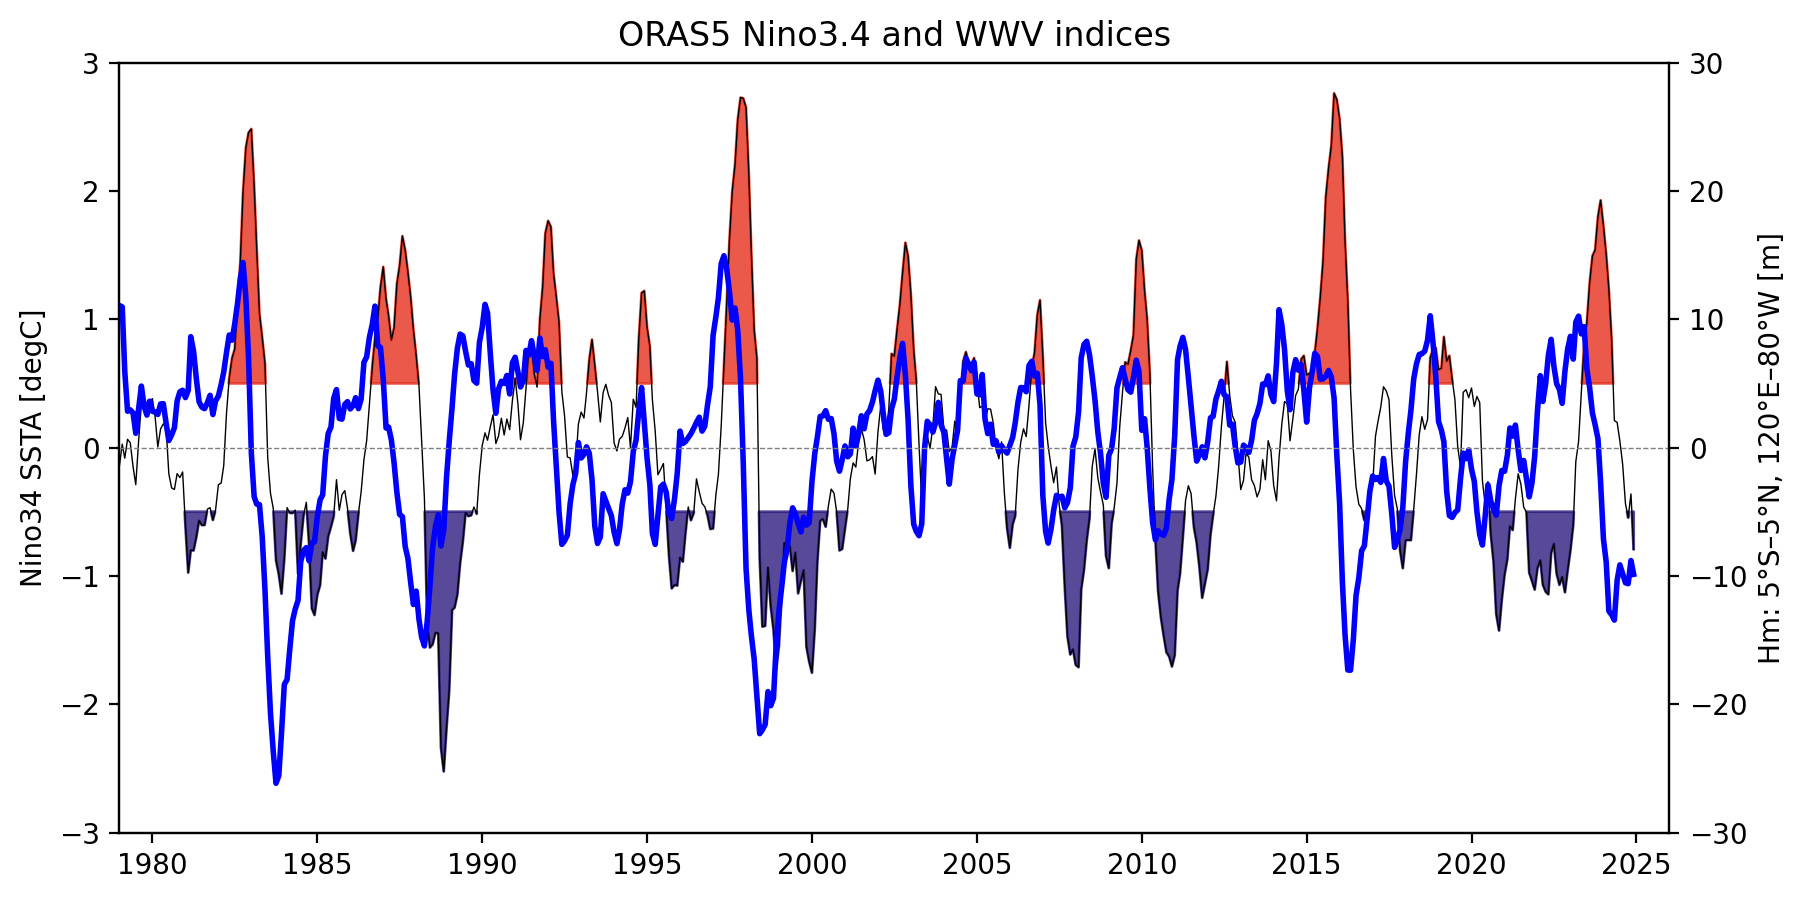

In [5]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
obs_ds = xr.open_dataset('../data/XRO_indices_oras5.nc').sel(time=slice('1979-01', '2024-12'))
obs_RO_ds = obs_ds[['Nino34', 'WWV']]
obs_XRO_ds = obs_ds[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]
print(obs_RO_ds)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plot_above_below_shading(obs_RO_ds['Nino34'], xtime=obs_RO_ds.time, c='black', lw=0.5, ax=ax)
# obs_RO_ds['Nino34'].plot(ax=ax, c='black', )
ax.set_ylim([-3, 3])
ax.set_ylabel('Nino34 SSTA [degC]')

axR = ax.twinx()
obs_RO_ds['WWV'].plot(ax=axR, c='blue', lw=2)
axR.set_ylim([-30, 30])
axR.axhline(0, ls='--', c='gray', lw=0.5)

ax.set_xlim([datetime.datetime(1979, 1, 1), datetime.datetime(2026, 1, 1)])
ax.set_title('ORAS5 Nino3.4 and WWV indices')

### 2.2 Observed ENSO seasonal synchronization

It can be represented as ENSO SSTA's seasonal variance (or standard deviation)

In [6]:
stddevAC_obs_ds = obs_RO_ds.groupby('time.month').std('time')
print(stddevAC_obs_ds)

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Nino34   (month) float64 1.142 0.9521 0.7425 0.5979 ... 1.039 1.195 1.224
    WWV      (month) float64 5.734 6.448 7.07 7.344 ... 7.267 7.673 7.049 6.229


Text(0.5, 1.0, 'ENSO seasonal synchronization')

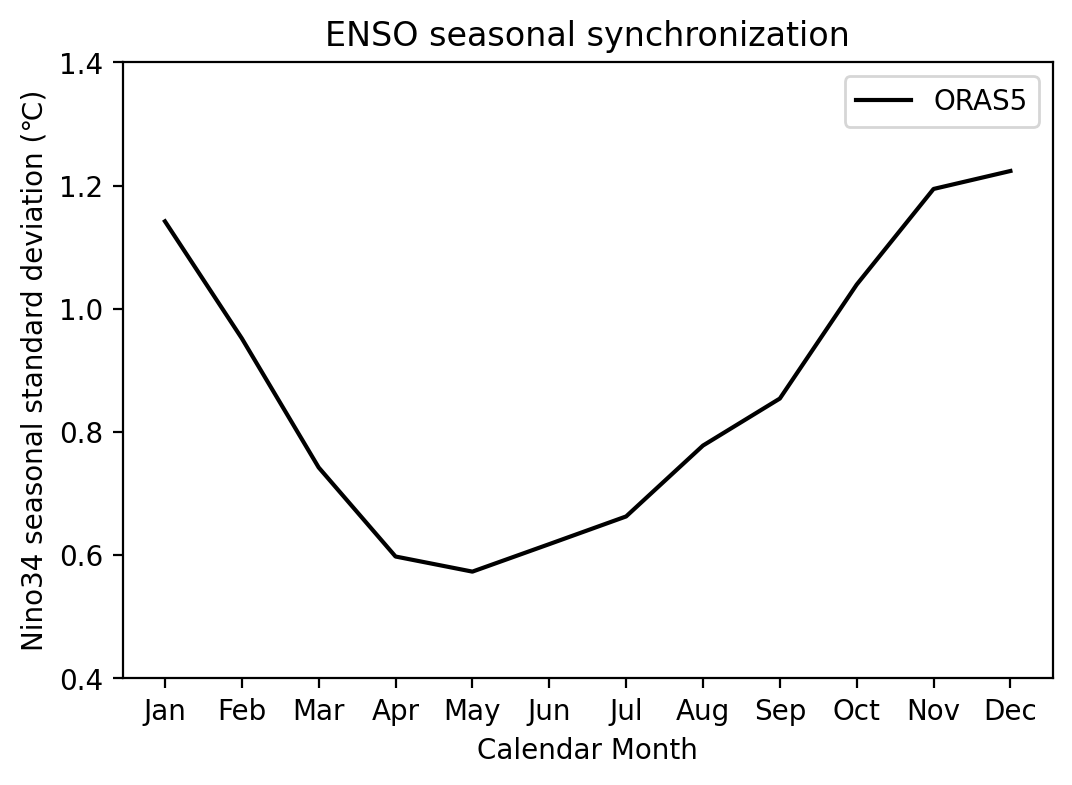

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plt.xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Nino34 seasonal standard deviation (℃)')
plt.xlabel('Calendar Month')
plt.legend()
plt.ylim([0.4, 1.4])
plt.title('ENSO seasonal synchronization')

### 2.3 Observed ENSO asymmetry and skewness

- check the function compute_skew in XRO_utils.py
- ENSO's skewness

In [8]:
skew_obs_ds = obs_RO_ds.skew('time')
print(skew_obs_ds)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    Nino34   float64 0.4996
    WWV      float64 -0.9064


### 2.4 ENSO SST-WWV relationships

In [9]:
ccr_obs_ds = xcorr(obs_RO_ds, obs_RO_ds['Nino34'], maxlags=36)
print(ccr_obs_ds)

<xarray.Dataset>
Dimensions:  (lag: 73)
Coordinates:
  * lag      (lag) int32 -36 -35 -34 -33 -32 -31 -30 ... 30 31 32 33 34 35 36
Data variables:
    Nino34   (lag) float64 0.0004787 0.001371 -0.008197 ... 0.001371 0.0004787
    WWV      (lag) float64 -0.1614 -0.1661 -0.1732 ... 0.2104 0.1919 0.1674


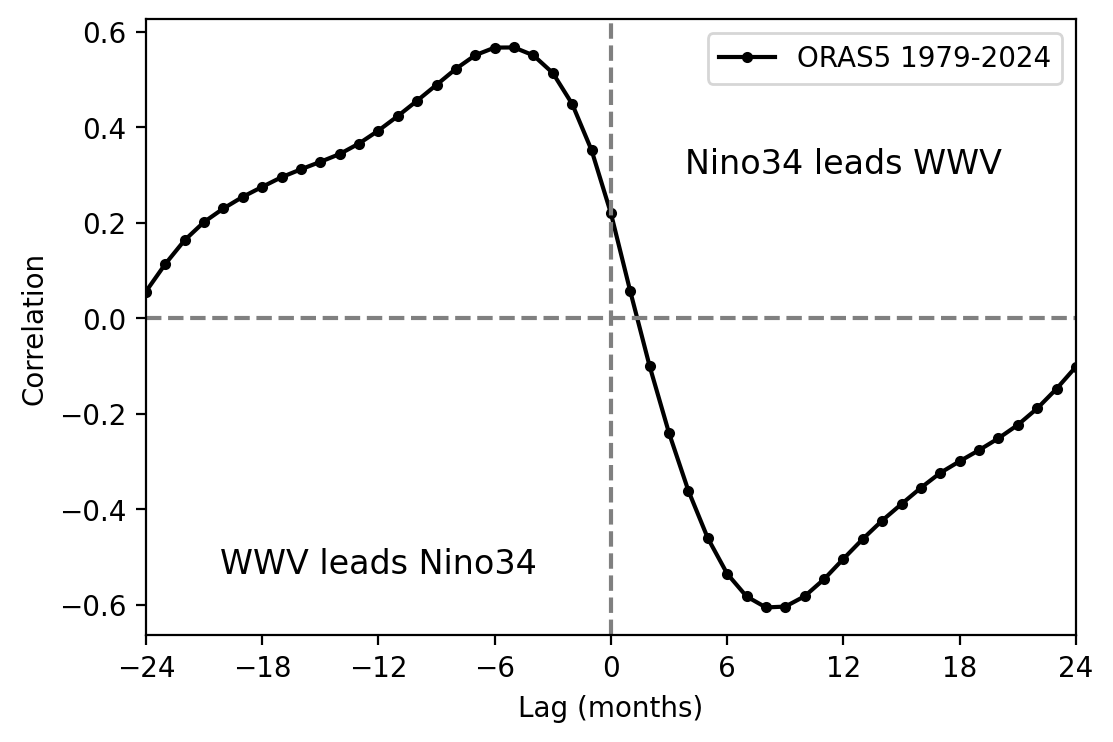

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sel_var = 'WWV'
ax.plot(ccr_obs_ds.lag, ccr_obs_ds[sel_var], c='black', marker='.', label='ORAS5 1979-2024')

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
ax.set_xlim([-24, 24])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

#### decadal shift in ENSO SST-WWV relationship
- McPhaden, M. J. (2012). A 21st century shift in the relationship between ENSO SST and warm water volume anomalies. Geophysical Research Letters, 39(9). https://doi.org/10.1029/2012GL051826

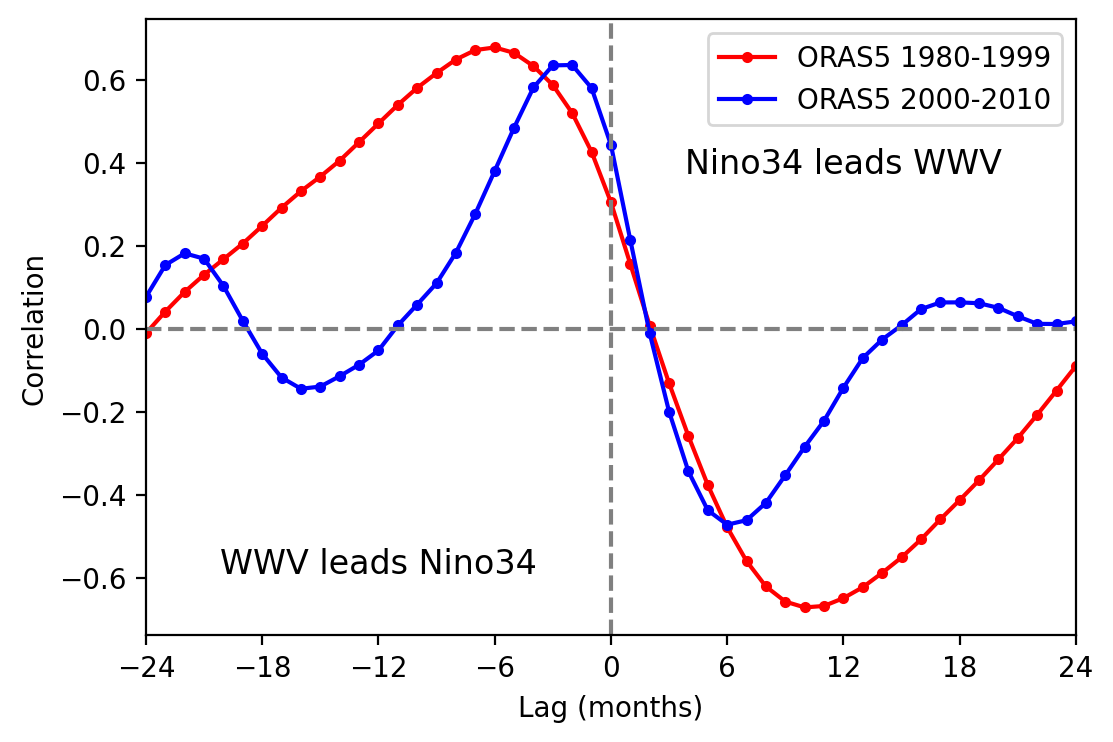

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

slice_P1 = slice('1980-01', '1999-12')
slice_P2 = slice('2000-01', '2010-12')
ccr_obs_P1 = xcorr(obs_RO_ds.sel(time=slice_P1), obs_RO_ds['Nino34'].sel(time=slice_P1), maxlags=36)
ccr_obs_P2 = xcorr(obs_RO_ds.sel(time=slice_P2), obs_RO_ds['Nino34'].sel(time=slice_P2), maxlags=36)

sel_var = 'WWV'
ax.plot(ccr_obs_P1.lag, ccr_obs_P1[sel_var], c='red', marker='.', label=f'ORAS5 {slice_P1.start[0:4]}-{slice_P1.stop[0:4]}')
ax.plot(ccr_obs_P2.lag, ccr_obs_P2[sel_var], c='blue', marker='.', label=f'ORAS5 {slice_P2.start[0:4]}-{slice_P2.stop[0:4]}')

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
ax.set_xlim([-24, 24])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

### 2.5 ENSO spectrum analysis

Thomson’s multitaper power spectral density (PSD) estimate
See pmtm in `XRO_utils.py`

**Combination mode**

Stuecker, M. F., Timmermann, A., Jin, F.-F., McGregor, S., & Ren, H.-L. (2013). A combination mode of the annual cycle and the El Niño/Southern Oscillation. Nature Geoscience, 6(7), 540–544. https://doi.org/10.1038/ngeo1826


In [12]:
psd_obs, psd_sig_obs, psd_ci_obs = pmtm( obs_RO_ds['Nino34'], dim='time', dt=1/12, nw=5)
print(psd_obs.coords)

Coordinates:
  * freq     (freq) float64 0.0 0.02174 0.04348 0.06522 ... 5.957 5.978 6.0


Text(0.5, 1.0, 'Spectrum of Niño3.4 SST anomaly')

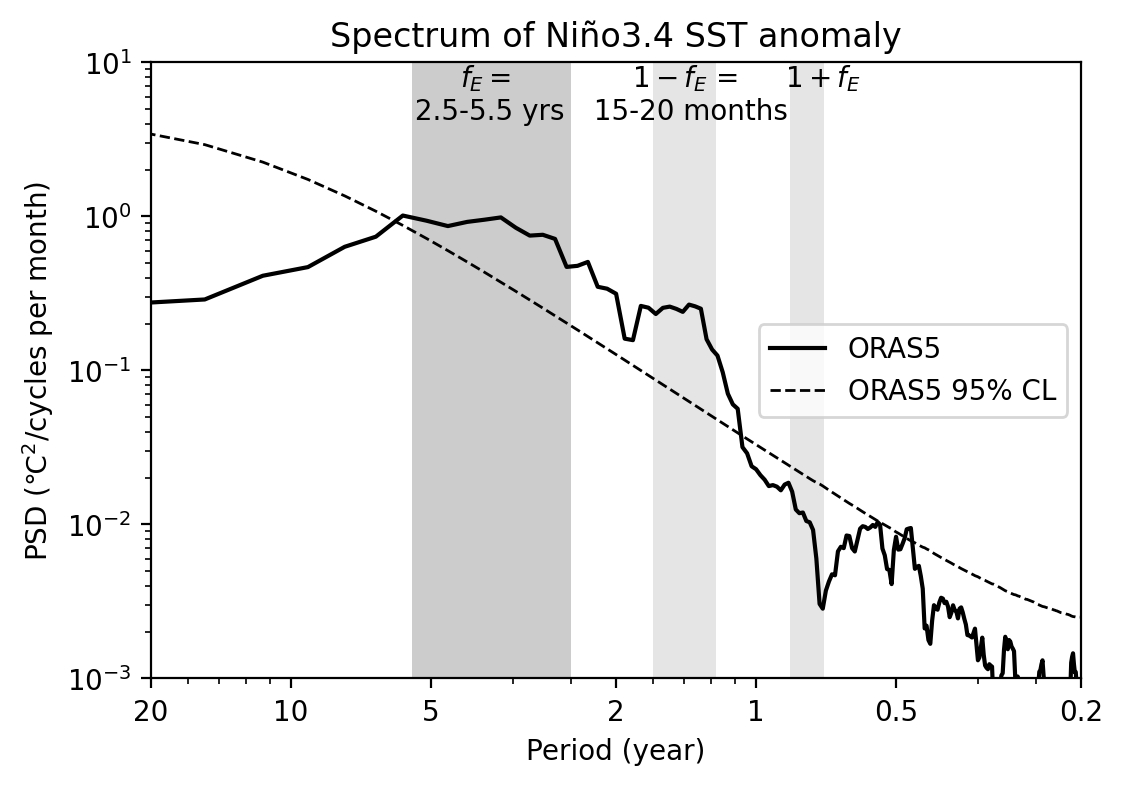

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.loglog(psd_obs.freq, psd_obs, lw=1.5, color='k', label='ORAS5')
ax.plot(psd_sig_obs.freq, psd_sig_obs, lw=1., color='k', linestyle='--', label='ORAS5 95% CL')

per = [50,20,10,5,2,1,0.5,0.2]
xt = 1.0/np.array(per)
ax.set_xticks(xt)
ax.set_xticklabels(map(str, per))
ax.set_ylabel('PSD (℃$^2$/cycles per month)')
ax.set_xlabel('Period (year)')
ax.set_xlim([1/20, 5])
ax.set_ylim([1e-3, 10])

ax.legend(loc='right')

y_min, y_max = ax.get_ylim()
Mfreq_enso = np.array([1/2.5, 1/5.5])
Mfreq_fplus = 1 + Mfreq_enso
Mfreq_fmins = 1 - Mfreq_enso

ax.fill_between(Mfreq_enso, y_min, y_max, fc='gray', alpha=0.4)
ax.fill_between(Mfreq_fplus, y_min, y_max, fc='gray',  alpha=0.2)
ax.fill_between(Mfreq_fmins, y_min, y_max, fc='gray', alpha=0.2)

ax.text(np.mean(Mfreq_enso)*0.9, y_max, '$f_{E}=$\n 2.5-5.5 yrs', ha='center', va='top')
ax.text(np.mean(Mfreq_fplus)+0.1, y_max, '$1+f_{E}$', ha='center', va='top')

ax.text(np.mean(Mfreq_fmins), y_max, '$1-f_{E}$ = \n 15-20 months', ha='center', va='top')
ax.set_title('Spectrum of Niño3.4 SST anomaly')

## 3. RO stochastic simulations with different complexities

### 3.1 Validating whether the fitted RO model reproduces observed properties
We fitted the RO model with observed Nino34 and WWV indices with full complexities

$$
\frac{dT}{dt} = R T + F_1 h + b_{T} T^2 - c_{T} T^3 + d_{T} T H + \sigma_T (1+B*H(T)*T)\xi_T
$$

$$
\frac{dh}{dt} = -\varepsilon h - F_2 T - b_h T^2 + \sigma_h \xi_h
$$


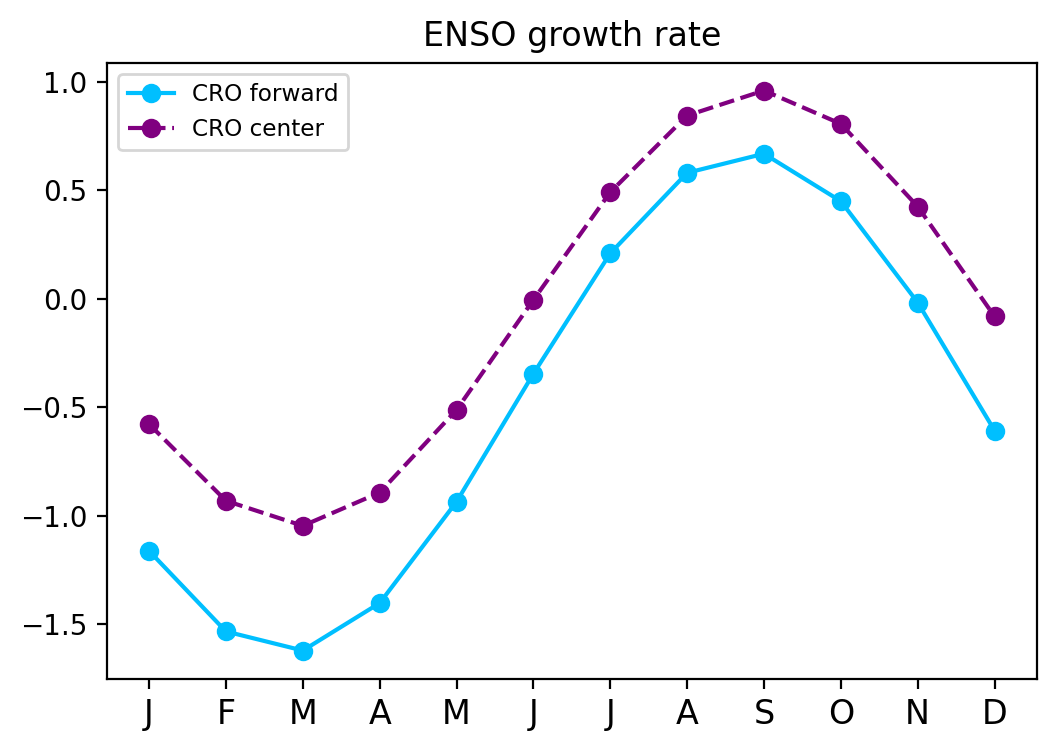

In [14]:
dt_fitting = 1.0 # with monthly input 

#Choose the type of RO to fit with T and h

T_option={'R': 3, 'F1': 3, 'b_T': 0, 'c_T': 0, 'd_T': 0} 
h_option={'F2': 3, 'epsilon': 3, 'b_h': 0}
noise_option_white = {'T': "white", 'h': "white", 'T_type': "additive"} 
noise_option_red  = {'T': "red", 'h': "red", 'T_type': "additive"} 

method_fitting='LR-C'
fit_CRO_para_C = RO_fitting(T=obs_RO_ds['Nino34'].values,
                          h=obs_RO_ds['WWV'].values,
                          T_option=T_option, 
                          h_option=h_option, 
                          noise_option=noise_option_white, 
                          method_fitting=method_fitting,
                          dt_fitting=1.0,)
fit_CRO_C = RO_BWJ_analysis(fit_CRO_para_C, deriative='C')

method_fitting='LR-F'
fit_CRO_para_F = RO_fitting(T=obs_RO_ds['Nino34'].values,
                          h=obs_RO_ds['WWV'].values,
                          T_option=T_option, 
                          h_option=h_option, 
                          noise_option=noise_option_white, 
                          method_fitting=method_fitting,
                          dt_fitting=1.0,)
fit_CRO_F = RO_BWJ_analysis(fit_CRO_para_F)



fig, ax=plt.subplots(1, 1, figsize=(6, 4))
xmonth = range(1, 13)

# ax.plot(xmonth, fit_CRO_F['R'], color='deepskyblue', marker='*', label='CRO forward')
# ax.plot(xmonth, fit_CRO_C['R'], color='purple', marker='o', ls='--', label='CRO center')


ax.plot(xmonth, fit_CRO_F['BJ'], color='deepskyblue', marker='.', ms=12, label='CRO forward')
ax.plot(xmonth, fit_CRO_C['BJ'], color='purple', marker='.', ms=12, ls='--', label='CRO center')

# ax.bar(xmonth, fit_CRO['BJ'], color='gray')
# ax.plot(xmonth, fit_XRO_F_ds['BJ_ac'], marker='o', color='red')

ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'], fontsize=12)
ax.set_title('ENSO growth rate')
ax.legend(fontsize='small')

# print(fit_CRO)
# print(fit_XRO_F_ds)

In [15]:
# Call RO_solver with parameters obtained on ORAS5 dataset.
# And generation of NE synthetic timeseries with the fitted parameters 

def RO_simulation(para, B=0, N = 100*12, NE = 100, output_type='snapshot', seed=None, derivative='F'):
    par = para
    par['B'] = B
    IC = obs_ds[['Nino34', 'WWV']].isel(time=0).to_array().values #Initial condition, arbitrary choice here
    # N = 100*12 #Lenght of the time series in month
    # NE = 100 # Number of members to generate
    EF = {'E_T':0.0,'E_h':0.0} #External forcing, null here.
    NM = 'EH' # numerical scheme
    dt = 0.1  # dt used in RO solver in month
    saveat = 1.0 # save every saveat month, needs to be an integer multiple of dt
    # output_type='snapshot' or output_type='monthly_mean'  
    #Call the RO solver function
    #This returns an ensemble of NE members of T,h and the white noises used for integration
    out_ds = RO_solver(par=par,IC=IC,N=N,NE=NE,EF=EF,NM=NM,dt=dt,
                        saveat=saveat,noise_custom=[], output_type=output_type, seed=seed, derivative=derivative)
    time = xr.cftime_range('1900-01', periods=len(out_ds.time), freq='MS')
    out_ds['time'] = time
    return out_ds.rename({'T': 'Nino34', 'h': 'WWV'})

sim_RO_F = RO_simulation(fit_CRO_para_F, B=0, N = 100*12, NE = 100, output_type='snapshot', derivative='F')
sim_RO_C = RO_simulation(fit_CRO_para_C, B=0, N = 100*12, NE = 100, output_type='snapshot', derivative='C')

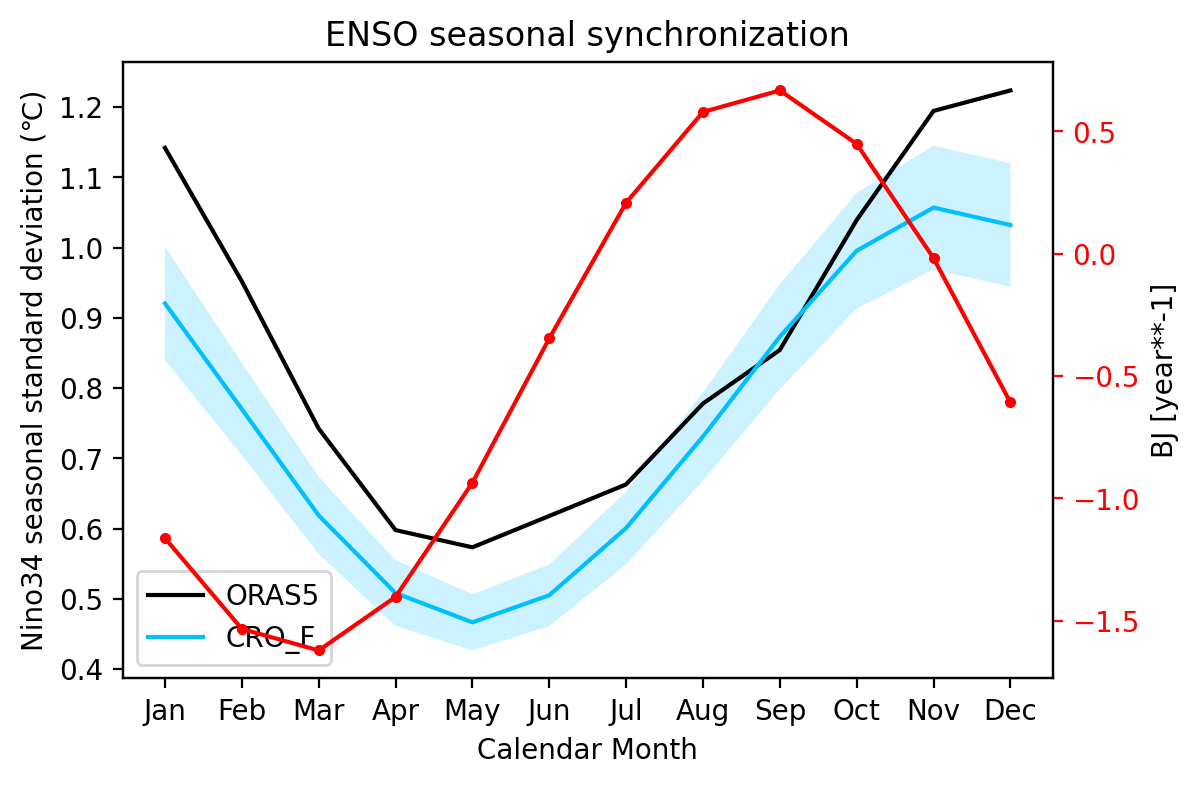

In [16]:
stddevAC_CRO_F_ds = sim_RO_F.groupby('time.month').std('time')
stddevAC_CRO_C_ds = sim_RO_C.groupby('time.month').std('time')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plot_fill_between(stddevAC_CRO_F_ds[sel_var], xtime=x_month, ax=ax, c='deepskyblue',  label='CRO_F')
# plot_fill_between(stddevAC_CRO_C_ds[sel_var], xtime=x_month, ax=ax, c='purple',  label='CRO_C')
axR=ax.twinx()
fit_CRO_F['BJ'].plot(c='red', marker='.', ax=axR)
axR.tick_params(axis='y', colors='red', labelcolor='red')
# axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
# ax.set_ylim([0.4, 1.4])
ax.set_title('ENSO seasonal synchronization')
ax.legend()

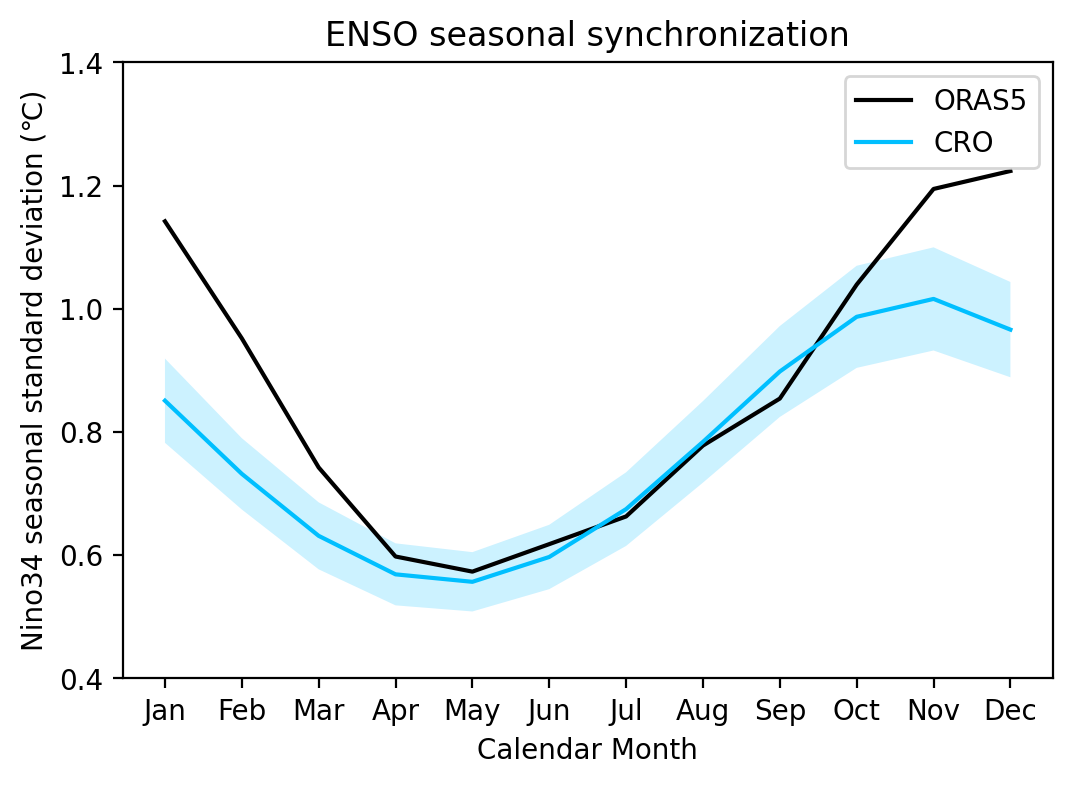

In [18]:
dt_fitting = 1.0 # with monthly input 

#Choose the type of RO to fit with T and h

T_option={'R': 3, 'F1': 1, 'b_T': 1, 'c_T': 1, 'd_T': 1} 
h_option={'F2': 1, 'epsilon': 1, 'b_h': 1}
noise_option_white = {'T': "white", 'h': "white", 'T_type': "additive"} 
noise_option_red  = {'T': "red", 'h': "red", 'T_type': "additive"} 

method_fitting='LR-F'
fit_CRO_para = RO_fitting(T=obs_RO_ds['Nino34'].values,
                          h=obs_RO_ds['WWV'].values,
                          T_option=T_option, 
                          h_option=h_option, 
                          noise_option=noise_option_white, 
                          method_fitting=method_fitting,
                          dt_fitting=1.0,)
fit_CRO = RO_BWJ_analysis(fit_CRO_para)
sim_CRO = RO_simulation(fit_CRO_para, B=0.0, N = 100*12, NE = 100, output_type='snapshot', derivative='F')

stddevAC_CRO_ds = sim_CRO.groupby('time.month').std('time')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plot_fill_between(stddevAC_CRO_ds[sel_var], xtime=x_month, ax=ax, c='deepskyblue',  label='CRO')
# axR=ax.twinx()
# fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
# axR.tick_params(axis='y', colors='red', labelcolor='red')
# # axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
ax.set_ylim([0.4, 1.4])
ax.set_title('ENSO seasonal synchronization')
ax.legend()